# Peak Set x Affinity

Break down of affinities for transient motifs by peak set.

**Inputs**:
1. Motif scans, perhaps filtered to important instances, along with log-odds scores.
2. Peak set BED files.

In [94]:
library(GenomicRanges)
library(ggplot2)
library(patchwork)
library(ggpubr)

## Load Input Data

### Peak Sets

In [3]:
PEAK_SET_BASE = "/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/"
PEAK_SET_BASE

[1] "/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/"

In [4]:
PEAK_SETS = c(8,10,11,13)

In [5]:
peak_sets_granges = list()
for (i in PEAK_SETS) {
    cur =  read.table(sprintf("%s/idx%d.bed", PEAK_SET_BASE, i))
    colnames(cur) = c("chr", "start", "end")
    peak_sets_granges[[i]] = GRanges(cur)
}

In [6]:
peak_sets_granges[[8]]

GRanges object with 22858 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     839897-840397      *
      [2]     chr1   1801493-1802694      *
      [3]     chr1   2118733-2119234      *
      [4]     chr1   2349814-2350613      *
      [5]     chr1   3803335-3803835      *
      ...      ...               ...    ...
  [22854]     chrY 18949318-18949818      *
  [22855]     chrY 19070047-19071211      *
  [22856]     chrY 19738653-19739153      *
  [22857]     chrY 20586136-20586636      *
  [22858]     chrY 20586865-20587586      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### Motif Scans

**TODO**: Generate scans reproducibly.

In [8]:
MOTIF_SCAN_BASE="/users/surag/kundajelab/scATAC-reprog/src/analysis/20210520_spacing_in_data/scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13"

In [68]:
MOTIFS = c("OCTSOX", "SOX.not.OCTSOX", "KLF","AP1.not.OCTSOX")

**CURRENTLY THESE ARE PEAKS IN HIGH_OSK STATE NOT OPEN IN FIBRS**

In [69]:
motif_scans = list()

for (x in MOTIFS) {
    cur = read.table(sprintf("%s/high_OSK.not.fibr.1000.%s.top_oneperc_imp.bed", MOTIF_SCAN_BASE, x))
    colnames(cur) = c("chr", "start", "end", "strand", "score", "seq")
    
    motif_scans[[x]] = GRanges(cur)
}

In [70]:
motif_scans[["OCTSOX"]]

GRanges object with 145616 ranges and 2 metadata columns:
           seqnames            ranges strand |     score             seq
              <Rle>         <IRanges>  <Rle> | <numeric>        <factor>
       [1]     chr1     840140-840154      - |  7.240431 ATATACTTGACAATA
       [2]     chr1   1191779-1191793      + |  6.785524 TATAGATATTCAGTT
       [3]     chr1   1638777-1638791      + |  6.882483 CTTTATTATGAAACA
       [4]     chr1   1801922-1801936      - |   7.47269 ATTAGTATCAGAAAA
       [5]     chr1   1828464-1828478      - |  6.104234 ATGTACACAACAATC
       ...      ...               ...    ... .       ...             ...
  [145612]     chrY 19739845-19739859      - |  6.468541 CACAGAATATGAAAG
  [145613]     chrY 20587098-20587112      - |  6.338637 GTTGGCATTAGAAAC
  [145614]     chrY 20599898-20599912      - |  6.819207 TTCAACATCACTATG
  [145615]     chrY 20600114-20600128      + |  8.457754 AATTCAAATTGAAAT
  [145616]     chrY 22744302-22744316      - |  6.325259 TTGTACAAC

In [71]:
names(motif_scans)

[1] "OCTSOX"         "SOX.not.OCTSOX" "KLF"            "AP1.not.OCTSOX"

## Plotting

In [120]:
extract_pset_score <- function(pset, mscans) {
    mscans[queryHits(findOverlaps(mscans, pset))]$score 
}

In [159]:
plot_per_tf <- function(psets, mscans, compare_list, title=NULL, xlabel=T, ylabel=T) {
    scores_vector = c()
    labels = c()
    
    for (x in PEAK_SETS) {
        cur = extract_pset_score(psets[[x]], mscans)
        
        scores_vector = c(scores_vector, cur)
        labels = c(labels, rep(x, length(cur)))
        
    }
    
    df = data.frame(log_odds=scores_vector,
                   peak_set=labels)
    
    p <- ggplot(df, aes(x=factor(peak_set), y=log_odds)) +
    geom_boxplot() +
    xlab("Peak Set") +
    ggtitle(title) +
    theme_bw(base_size=26) +
    theme(plot.title = element_text(hjust = 0.5))
#     stat_compare_means(comparisons = compare_list) # NOT ADJUSTED P VALUES
    
    if (ylabel==T) {
        p = p + ylab("Log-odds Score")
    }
    
    else {
        p = p + theme(axis.title.y=element_blank())
    }
    
    p
}

In [160]:
COMPARE_LIST = list(c("8", "10"), c("10", "11") , c("11", "13"), c("8", "13"))

In [161]:
os_plot = plot_per_tf(peak_sets_granges, motif_scans[["OCTSOX"]], COMPARE_LIST, title="OCTSOX")
sox_plot = plot_per_tf(peak_sets_granges, motif_scans[["SOX.not.OCTSOX"]], COMPARE_LIST, title="SOX", ylabel=F)
klf_plot = plot_per_tf(peak_sets_granges, motif_scans[["KLF"]], COMPARE_LIST, title="KLF")
ap1_plot = plot_per_tf(peak_sets_granges, motif_scans[["AP1.not.OCTSOX"]], COMPARE_LIST, title="AP1", ylabel=F)

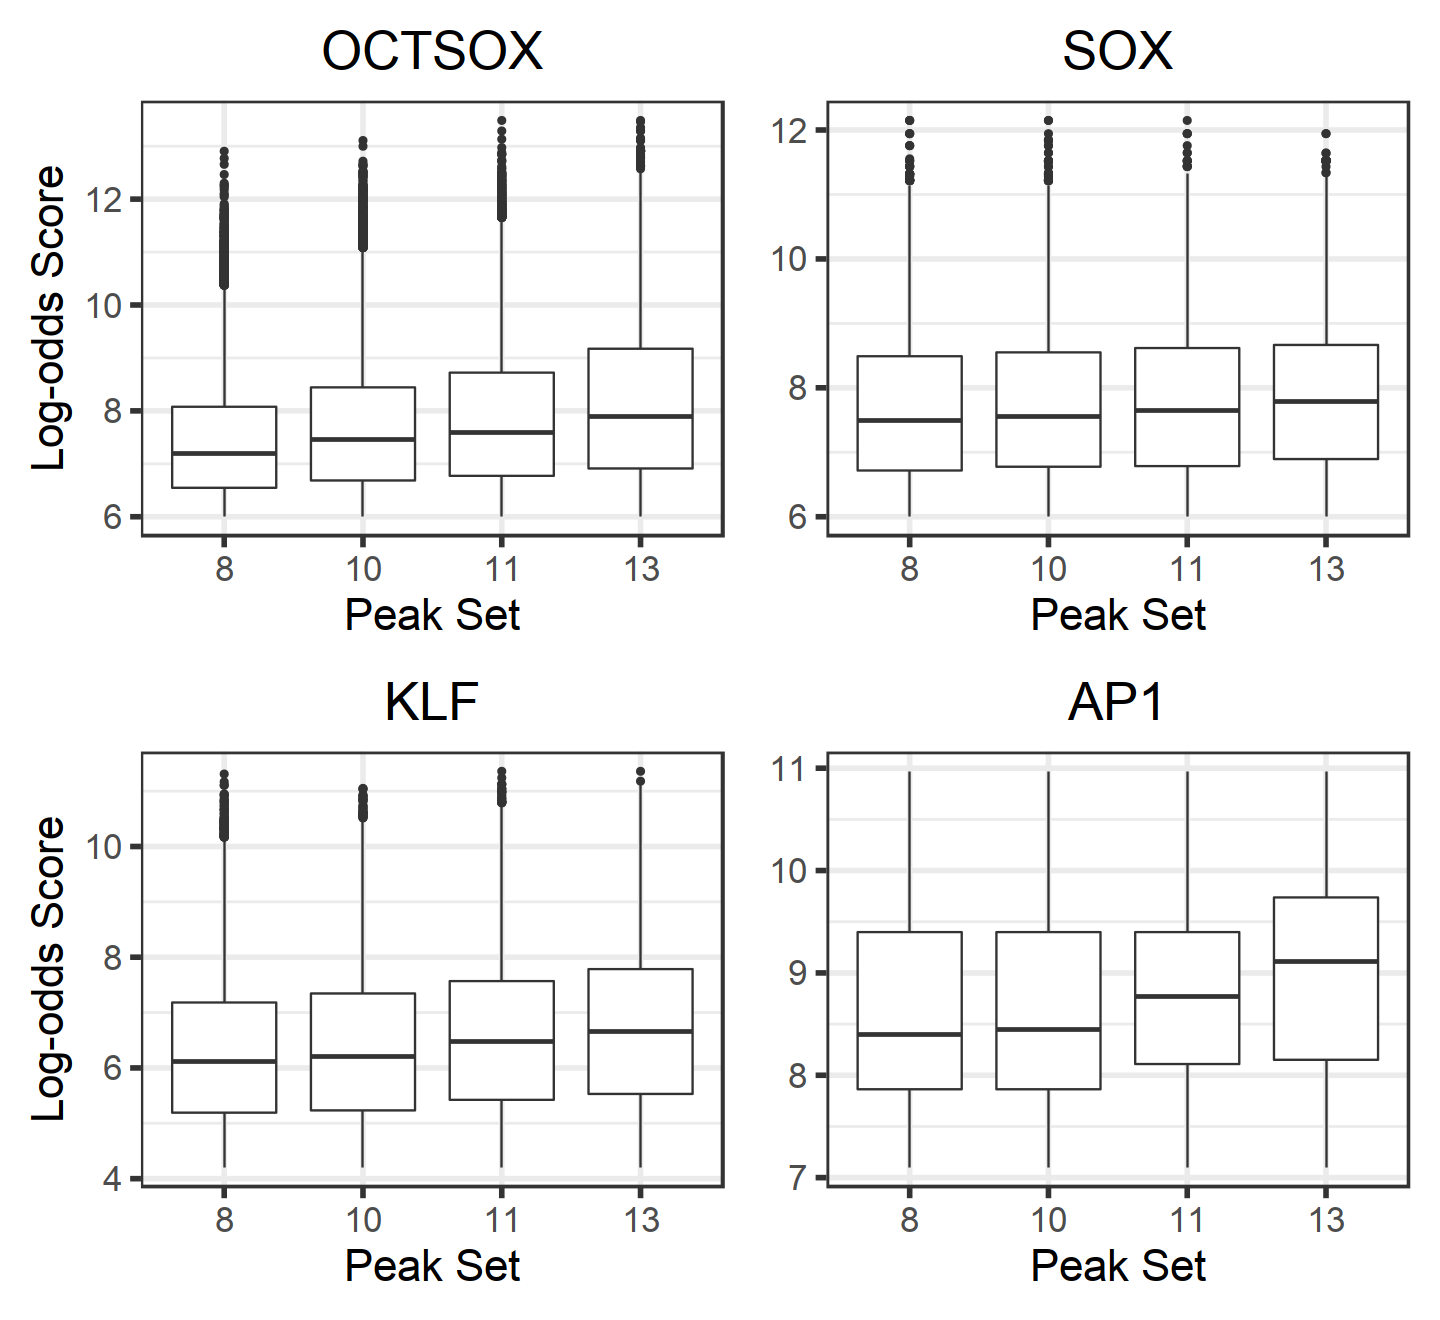

In [167]:
options(repr.plot.width = 12, repr.plot.height = 11)

(os_plot | sox_plot) /
(klf_plot | ap1_plot)